In [200]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Machine Learning Engineer Nanodegree
## Capstone Project 
### Airbnb New  User Booking Dataset
Pin-Yi Tseng
October 13th, 2018

## I. Definition
_____

### Project Overview

The distance between countries are becoming shorter due to faster transportation like airplanes and trains; on the other hand, thanks for broadband universal service, people tend to share their daily life, experiences, special events, etc. on Facebook or Instagram. Instead of joining in traveling agency, more and more people get their bag, pick up destinations and take off their adventures by themselves or with a small group of their friends. Companies like Airbnb, Booking.com, Agoda, trivago, and so on booming nowadays. People tend to continuously use their familiar and trust website when booking their hostels, especially when they become VIPs after many purchases. Therefore, the way to correctly predict the destination, providing related service or recommendation and attract people when they make their first consumption is the critical point for getting long-term customers.

Airbnb has become a global platform that connects travelers and hosts from over 34,000 cities. As such, it has collected a diverse set of dataset about users which can be utilized to predict patterns about its future users and provide them with customized suggestions to serve Airbnb's customers Airbnb had posted this on Kaggle as a Recruitment Challenge. Using user data could help organizations increase metrics such as sales, user experience, customer retention, and customer satisfaction. Apply Machine Learning methodology can help the organization to reveal the mutual effect between different events And furthermore, making the prediction using these data. The motivation for pursuing this project is to understand how to work on real-world datasets and challenges that companies like Airbnb consider to be important and valuable for their companies and learn to provide similar value for organizations that I Work with in the future.

The related work using machine learning method for recommendation system has been done in Book recommending using text categorization with extracted information. This paper focus on content-based recommender systems suggest documents, items, and services to users based on learning a profile of the user from rated examples containing information about the given items. Text categorization methods are very useful for this task but generally rely on unstructured text. We have developed a book-recommending system that utilizes semi-structured information about items gathered from the web using simple information extraction techniques. Initial experimental results demonstrate that this approach can produce fairly accurate recommendations.

### Problem Statement

By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

Using the data from [Airbnb New User Bookings](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings) dataset, the challenge is to predict the destination of choice for the users' first booking. This data includes demographics of users and their session data. The model will utilize these demographics and session data to make models that can predict the destinations.

In this project, I plan to use Machine Learning Techniques to predict in which country a new user will make their first booking on Airbnb. This project will involve data cleaning, data exploration using visualizations, and testing various algorithms for classification for the same.

### Evaluation Metrics
Since this is a Kaggle Challenge, we already have an evaluation metric, that is the NDCG (Normalized Discounted Cumulative Gain)

Original method: For each new user, we are to make a maximum of 5 predictions on the country of the first booking. The ground truth country is marked with relevance = 1, while the rest have relevance = 0.

$DCG_k=\sum_{i=1}^k\frac{2^{gain_i}-1}{\log_2{\left(i+1\right)}}$

$nDCG_k=\frac{DCG_k}{IDCG_k}$

where $gain_i$ is the gain of the result at position $i$ and $k = 5$.

For example, if for a particular user the destination is FR, then the predictions become:

[ FR ] gives a $NDCG=\frac{2^{1}-1}{log_{2}(1+1)}=1.0$

[ US, FR ] gives a $DCG=\frac{2^{0}-1}{log_{2}(1+1)}+\frac{2^{1}-1}{log_{2}(2+1)}=\frac{1}{1.58496}=0.6309$


##### I tried to do some Improvment Based on http://dalelane.co.uk/blog/?p=3403. However, I found there're some reasons that this function may fail. So, for this analysis, I'll keep this default Evaluation Matrics while I'll explain my trial results in this **Improvment" part.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime, date
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display
import gc
import xgboost as xgb
import operator
import warnings
warnings.filterwarnings('ignore')

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)

## II. Analysis

### Data Exploration

The train users data file has 213451 rows, where each rows describes 15 features about the user. The target variable is `country_destination`.

In [6]:
train_users_path = 'data/train_users_2.csv'
test_users_path = 'data/test_users.csv'

# train_users
train_users = pd.read_csv(train_users_path)
target = train_users['country_destination']
train_users = train_users.drop(['country_destination'], axis=1)

# test_users
test_users = pd.read_csv(test_users_path)

# Combine train and test dataset for cleaning
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)

print("Number of rows, columns in users dataframe: " + str(users.shape))

Number of rows, columns in users dataframe: (275547, 15)


#### train_users/test_users
- id: user id
- date_account_created: the date of account creation
- timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
- date_first_booking: date of first booking
- gender
- age
- signup_method
- signup_flow: the page a user came to signup up from
- language: international language preference
- affiliate_channel: what kind of paid marketing
- affiliate_provider: where the marketing is e.g. google, craigslist, other
- first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
- signup_app
- first_device_type
- first_browser
- country_destination: this is the **target** variable you are to predict
- sessions.csv - web sessions log for users

### Exploratory Visualization
Before starting, it was important to find out the percentage of missing values. It was found that `date_first_booking` not available for the testing dataset. Also, I infered that date_first_booking is only available for users who successfully booked a destination and since `NDF` is the most frequent, it is implicit that `date_first_booking` would be missing. So, I decided to drop this feature.

In [35]:
# Display percentage of missing data
#display((users.isnull().sum() / users.shape[0]) * 100)
print("Percentage of missing data by column in train_users.csv")
display((test_users.isnull().sum() / test_users.shape[0]) * 100)

print("----------------------------------------------")

print("Percentage of missing data by column in test_users.csv")
display((train_users.isnull().sum() / train_users.shape[0]) * 100)

Percentage of missing data by column in train_users.csv


id                           0.000000
date_account_created         0.000000
timestamp_first_active       0.000000
date_first_booking         100.000000
gender                       0.000000
age                         46.502190
signup_method                0.000000
signup_flow                  0.000000
language                     0.000000
affiliate_channel            0.000000
affiliate_provider           0.000000
first_affiliate_tracked      0.032208
signup_app                   0.000000
first_device_type            0.000000
first_browser                0.000000
dtype: float64

----------------------------------------------
Percentage of missing data by column in test_users.csv


id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                      0.000000
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.841402
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
dtype: float64

In [36]:
users.index = users.id
users = users.fillna(-1)

users = users.drop(['date_first_booking'], axis=1)

The plot below shows the frequency of the target variable. There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

[Text(0,0.5,'frequency'), Text(0.5,0,'countries')]

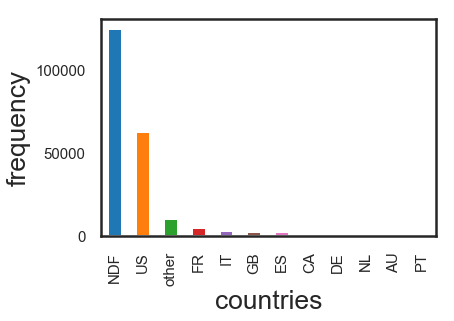

In [37]:
target.value_counts().plot(kind='bar',fontsize=15).set(xlabel='countries', ylabel='frequency')

After solving the `date_first_booking` feature, we explored the gender data. It was found that most of the data was not filled by the user and was set as `-unknown-` in the dataset. 

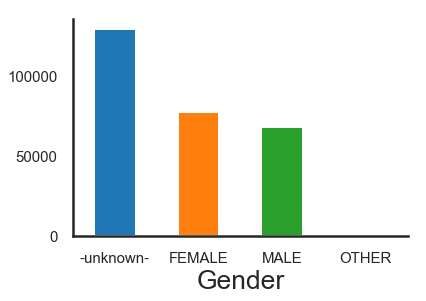

In [38]:
users.gender.value_counts(dropna=False).plot(kind='bar', rot=0,fontsize=15)
plt.xlabel('Gender')
sns.despine()

users = users.replace('-unknown-', -1)

Then, it was found that the Age was also having erroneous values such as `2014`, and negative values etc, I decided to set values `< 15` and `> 100` as `NaN`. The visualization is displayed below:

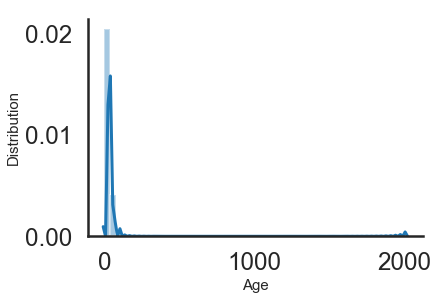

In [39]:
sns.distplot(users.age.dropna())
plt.xlabel('Age',fontsize=15)
plt.ylabel('Distribution',fontsize=15)
sns.despine()

### Algorithms and Techniques

Given that this problem was a multi-class supervised classification problem, we decided to use Decision Trees. Decision trees are powerful in predicting a target by learning simle decision rules learnt using training data. They can handle numerical and categorical data, missing data, along with multiple target classes. 

Although decision trees are good, I decided to use ensemble methods to improve the predictive power. These algorithms were, the random forest classifier and XGBoost. 

**Random Forest** Classifier fits number of decision trees on subsamples of a dataset and averages the results. 

A random forest is a collection of random decision trees. In which at each node you will randomly draw a subset of features and the decision tree will predict the classification. Then the same is done with several trees and bagged. This ensemble method will reduce overfitting and provide good classification. The bias-variance trade-off for this algorithm is good and therefore the possibility of overfitting is drastically reduced.

**GridSearchCV** There are many parameters which can be tuned to get a model with very good accuracy. The grid search technique helps us to generate a grid from parameters and use these multiple combinations of parameters and then select the best one which provides best cross-validation results. Although, it is important to note here that the grid search technique only performs hyper-parameter tuning, i.e. the parameters that are not directly learnt within the estimator.
In scikit-learn, we have GridSearchCV which uses an estimator and a set of hyper-parameters to exhaustively generates candidates from set and generate a validation score and we can then obtain the most optimal parameters systematically. We use this technique to get the best hyperparameters for our Random Forest ensemble.

The **XGBoost** algorithm was choosen after research into Kaggle Competitions and it was found out that it proves extremely effective in such arenas. XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It produces an ensemble of weak decision tree learners via additive training (boosting). XGBoost is short for Extreme Gradient Boosting. This is based on Gradient boosted trees. Boosted trees are basically an ensemble of decision trees which are fit sequentially so that each new tree makes up for errors in the previously existing set of trees. The model is ”boosted” by focusing new additions on correcting the residual errors of the last version of the model. Then you take an approximate step in the gradient direction by training a model to predict the gradient given the data. XGBoost algorithm tuning is a tricky process. Heavy computation power is required for such level of tuning.

### Benchmark - SVM

The given dataset is a typical supervised learning problem and so far SVM is the algorithm I used mot of time. So I will pick Support Vector Machine (SVM) as a benchmark. In addition, if we set `svc.probability = True`, then this sklearn module allows us to predict each destination with their probability. Then, we choose the top 5 possibility as our results, and I get score of  `0.7647` in benchmark model.

In [56]:
# Since we have more than 150 features which makes it spends a long long time for calculation.
# It takes me more than 30 minutes to wait for the result, but this method seemed to need more time, so I failed to get; 
# so, I think this may be a better solution to choose the top 30 relevance features instead.
# Uncomment to Load from Checkpoint
users = pd.read_pickle('users_checkpoint1')
users_svc2 = users[top_features]

vals = users_svc2.values
le = LabelEncoder()

X = vals[:piv_train]
y = le.fit_transform(target.values)

from sklearn.svm import SVC
clf_svc = SVC()
clf_svc.probability = True
clf_svc.fit(X[:10000], y[:10000])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [71]:
y_pred = clf_svc.predict_proba(X)

truth = pd.Series(le.inverse_transform(y))
preds = []

for i in range(len(X)):
    preds += [le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()]

preds = pd.DataFrame(preds)
print("Score for SVM: " + str(score_predictions(preds, truth)))

Score for SVM: 0.7646723769173576


## III. Methodology

### Data Preprocessing
#### Age
As discussed above, we set the ages below 15 and above 100 to NaN. Afterwards, we One Hot Encoded the age in intervals of 5.
After removing these values the distribution of age looks like this:

count    155932.000000
mean         36.055043
std          11.663664
min          15.000000
25%          28.000000
50%          33.000000
75%          42.000000
max         100.000000
Name: age, dtype: float64

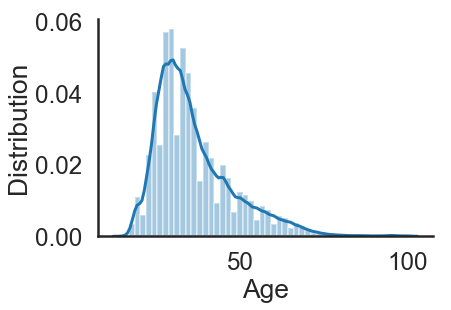

In [40]:
# Remove users with 
users.age.loc[users.age < 15] = np.nan
users.age.loc[users.age > 100] = np.nan

sns.distplot(users.age.dropna())
plt.xlabel('Age')
plt.ylabel('Distribution')
sns.despine()

users.age.describe()

## Creating Features And One-hot-encoding(OHE)

- One-hot encoding of the age according to intervals of 5: People in different age ranges must have different idea when choosing traveling place.

In [41]:
#(One-hot encoding of the age according these intervals)
interv =  [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100]
def get_interv_value(age):
    iv = 20
    for i in range(len(interv)):
        if age < interv[i]:
            iv = i 
            break
    return iv
users['age_interv'] = users.age.apply(lambda x: get_interv_value(x))
users_ai = pd.get_dummies(users.age_interv, prefix='age_interv')
users = users.drop(['age_interv'], axis=1)
users = pd.concat((users, users_ai), axis=1)

display(users.head())

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,age_interv_11,age_interv_12,age_interv_13,age_interv_14,age_interv_15,age_interv_16,age_interv_17,age_interv_18,age_interv_19,age_interv_20
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,2010-06-28,20090319043255,-1,NaN,facebook,0,en,direct,direct,...,0,0,0,0,0,0,0,0,0,1
820tgsjxq7,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,...,0,0,0,0,0,0,0,0,0,0
4ft3gnwmtx,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,...,0,1,0,0,0,0,0,0,0,0
bjjt8pjhuk,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,...,0,0,0,0,0,0,0,0,0,0
87mebub9p4,87mebub9p4,2010-09-14,20091208061105,-1,41.0,basic,0,en,direct,direct,...,0,0,0,0,0,0,0,0,0,0


Since column related to `date` can only provide limited use when analyzing, here I decide to separate date related column into several pieces, such as `year`, `month`, `day`, `numbers of week in one year` and `weekday`. By doing this, new features may give us more information about how people decide to choose their countries, maybe this is affected by months (trying to avoid extremely cold, hot or dangerous weather conditions); or maybe some people prefer doing something on certain weekday. For example, during Monday blue, people may have an urgent feel to some natural places.

In addition, the format for `date_account_created` and `timestamp_first_active` are different; which means by doing this, we can transform those 2 features into some others with the same format.

- date_account_created: We used this date column and split it into `dac_y`, `dac_m`, `dac_d`, `dac_wn` (week number), `dac_w_{}` (weekday, it was further split into each day).

In [42]:
#date_account_created
dac = np.vstack(users.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
users['dac_y'] = dac[:,0]
users['dac_m'] = dac[:,1]
users['dac_d'] = dac[:,2]
dac_dates = [datetime(x[0],x[1],x[2]) for x in dac]
users['dac_wn'] = np.array([d.isocalendar()[1] for d in dac_dates]) #week number
users['dac_w'] = np.array([d.weekday() for d in dac_dates]) #week day
users_wd = pd.get_dummies(users.dac_w, prefix='dac_w')
users = users.drop(['date_account_created', 'dac_w'], axis=1)
users = pd.concat((users, users_wd), axis=1)

display(users.head())

,id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,dac_m,dac_d,dac_wn,dac_w_0,dac_w_1,dac_w_2,dac_w_3,dac_w_4,dac_w_5,dac_w_6
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,20090319043255,-1,NaN,facebook,0,en,direct,direct,untracked,...,6,28,26,1,0,0,0,0,0,0
820tgsjxq7,820tgsjxq7,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,...,5,25,21,0,0,1,0,0,0,0
4ft3gnwmtx,4ft3gnwmtx,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,...,9,28,39,0,1,0,0,0,0,0
bjjt8pjhuk,bjjt8pjhuk,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,...,12,5,49,1,0,0,0,0,0,0
87mebub9p4,87mebub9p4,20091208061105,-1,41.0,basic,0,en,direct,direct,untracked,...,9,14,37,0,1,0,0,0,0,0


- timestamp_first_active: Similar treatment was given to the Timestamp First Active with new columns added as `tfa_y`, `tfa_m`, `tfa_d`, `tfa_h` (hour), `tfa_wn` (week number), `tfa_w_{}` (weekday, it was further split into each day).

In [43]:
tfa = np.vstack(users.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
users['tfa_y'] = tfa[:,0]
users['tfa_m'] = tfa[:,1]
users['tfa_d'] = tfa[:,2]
users['tfa_h'] = tfa[:,3]
tfa_dates = [datetime(x[0],x[1],x[2],x[3],x[4],x[5]) for x in tfa]
users['tfa_wn'] = np.array([d.isocalendar()[1] for d in tfa_dates])
users['tfa_w'] = np.array([d.weekday() for d in tfa_dates])
users_wd = pd.get_dummies(users.tfa_w, prefix='tfa_w')
users = users.drop(['timestamp_first_active', 'tfa_w'], axis=1)
users = pd.concat((users, users_wd), axis=1)

display(users.head())

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,tfa_d,tfa_h,tfa_wn,tfa_w_0,tfa_w_1,tfa_w_2,tfa_w_3,tfa_w_4,tfa_w_5,tfa_w_6
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,-1,NaN,facebook,0,en,direct,direct,untracked,Web,...,19,4,12,0,0,0,1,0,0,0
820tgsjxq7,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,untracked,Web,...,23,17,21,0,0,0,0,0,1,0
4ft3gnwmtx,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,...,9,23,24,0,1,0,0,0,0,0
bjjt8pjhuk,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,...,31,6,44,0,0,0,0,0,1,0
87mebub9p4,87mebub9p4,-1,41.0,basic,0,en,direct,direct,untracked,Web,...,8,6,50,0,1,0,0,0,0,0


- Season (engineered feature): Using our studied domain knowledge, we know that season of booking can affect the destination choices. For example, people tend to visit cold places or beaches in summer, while the opposite is true in winter. We added two new features `season_dac` and `season_tfa`.

In [44]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [(0, (date(Y,  1,  1),  date(Y,  3, 20))),  #'winter'
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),  #'spring'
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),  #'summer'
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),  #'autumn'
           (0, (date(Y, 12, 21),  date(Y, 12, 31)))]  #'winter'
def get_season(dt):
    dt = dt.date()
    dt = dt.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= dt <= end)
users['season_dac'] = np.array([get_season(dt) for dt in dac_dates])
users['season_tfa'] = np.array([get_season(dt) for dt in tfa_dates])

display(users.head())

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,tfa_wn,tfa_w_0,tfa_w_1,tfa_w_2,tfa_w_3,tfa_w_4,tfa_w_5,tfa_w_6,season_dac,season_tfa
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,-1,NaN,facebook,0,en,direct,direct,untracked,Web,...,12,0,0,0,1,0,0,0,2,0
820tgsjxq7,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,untracked,Web,...,21,0,0,0,0,0,1,0,1,1
4ft3gnwmtx,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,...,24,0,1,0,0,0,0,0,3,1
bjjt8pjhuk,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,...,44,0,0,0,0,0,1,0,3,3
87mebub9p4,87mebub9p4,-1,41.0,basic,0,en,direct,direct,untracked,Web,...,50,0,1,0,0,0,0,0,2,3


- One-hot-encoding: Other categorical features had to be further one hot encoded. `['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']` were encoded.

In [45]:
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    users_dummy = pd.get_dummies(users[f], prefix=f)
    users = users.drop([f], axis=1)
    users = pd.concat((users, users_dummy), axis=1)

display(users.head())

,id,age,age_interv_4,age_interv_5,age_interv_6,age_interv_7,age_interv_8,age_interv_9,age_interv_10,age_interv_11,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
820tgsjxq7,820tgsjxq7,38.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4ft3gnwmtx,4ft3gnwmtx,56.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bjjt8pjhuk,bjjt8pjhuk,42.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
87mebub9p4,87mebub9p4,41.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


- Since `id` does not provide any inforamtion, we remove is. If there is any null value left, we replace it with `-1` 

In [46]:
users = users.drop(['id'], axis=1)
users = users.fillna(-1)

print("We ended up with "+str(users.shape[1])+" columns after data preprocessing.")

We ended up with 197 columns after data preprocessing.


### Checkpoint

In [47]:
# Save as
users.to_pickle('users_checkpoint1')

In [48]:
# Uncomment to Load from Checkpoint
users = pd.read_pickle('users_checkpoint1')

### Implementation

#### Evaluation Metrics: NDCG Scoring Function
ref: https://www.kaggle.com/dietcoke/score-predictions-using-ndcg

In [37]:
def dcg_at_k(r, k, method=1):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k=5, method=1):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def score_predictions(preds, truth, n_modes=5):
    """
    preds: pd.DataFrame
      one row for each observation, one column for each prediction.
      Columns are sorted from left to right descending in order of likelihood.
    truth: pd.Series
      one row for each obeservation.
    """
    assert(len(preds)==len(truth))

    r = pd.DataFrame(0, index=preds.index, columns=preds.columns, dtype=np.float64)
    for col in preds.columns:
        r[col] = (preds[col] == truth) * 1.0

    score = pd.Series(r.apply(ndcg_at_k, axis=1, reduce=True), name='score')
    return score.mean()

In [38]:
# Test
preds = pd.DataFrame([['US','FR','IT','CA'],['FR','US','AR','AU'],['FR','ES','GB','NL']])
truth = pd.Series(['US','FR','DE'])

print(score_predictions(preds, truth))

0.6666666666666666


In [39]:
"""Metrics to compute the model performance."""
# ref: https://www.kaggle.com/davidgasquez/airbnb-recruiting-new-user-bookings/ndcg-scorer
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.
        
    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    #lb.fit(range(len(predictions) + 1))  ## original
    #lb.fit(range(predictions.shape[1] + 1))
    #T = lb.transform(ground_truth)
    
    T = lb.fit_transform(ground_truth) 

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

#### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [161]:
# Uncomment to Load from Checkpoint
users = pd.read_pickle('users_checkpoint1')

vals = users.values
piv_train = len(target)
X = vals[:piv_train]
X_test = vals[piv_train:]

# Create numeric label for each of the 12 target labels
labels = target.values
le = LabelEncoder()
y = le.fit_transform(labels)

In [162]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 170760 samples.
Testing set has 42691 samples.


#### Random Forest

In [163]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from time import time

def train_predict_RF(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict_proba(X_test)
    predictions_train = learner.predict_proba(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    truth = pd.Series(le.inverse_transform(y_train[:300]))
    preds = []
    for i in range(len(predictions_train)):
        preds += [le.inverse_transform(np.argsort(predictions_train[i])[::-1])[:5].tolist()]

    preds = pd.DataFrame(preds)
    results['ncdg_train'] = score_predictions(preds, truth)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    truth = pd.Series(le.inverse_transform(y_test))
    preds = []
    for i in range(len(predictions_test)):
        preds += [le.inverse_transform(np.argsort(predictions_test[i])[::-1])[:5].tolist()]

    preds = pd.DataFrame(preds)
    results['ncdg_test'] = score_predictions(preds, truth)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [164]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators=25, random_state=101)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
clf_name = clf_RF.__class__.__name__
results[clf_name] = {}
for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict_RF(clf_RF, samples, X_train, y_train, X_test, y_test)
   

#Run metrics visualization for the three supervised learning models chosen
#vs.evaluate(results, accuracy, fscore)

RandomForestClassifier trained on 1707 samples.
RandomForestClassifier trained on 17076 samples.
RandomForestClassifier trained on 170760 samples.


#### XGBoost

#### Feature Importances
ref: https://www.kaggle.com/kevinwu06/feature-importance-w-xgboost

In [165]:
# Uncomment to Load from Checkpoint
users = pd.read_pickle('users_checkpoint1')

In [166]:
from sklearn.model_selection import train_test_split

piv_train = len(target) #Marker to split users into train + test
vals = users.values
le = LabelEncoder()

X = vals[:piv_train]
y = le.fit_transform(target.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test_set = vals[piv_train:]

In [167]:
# XGB Classifier Parameters
params = {'eta': 0.2,
          'max_depth': 6,
          'subsample': 0.5,
          'colsample_bytree': 0.5,
          'objective': 'multi:softprob',
          'num_class': 12}

In [168]:
# First train on whole training set for feature importances
num_boost_round = 1
dtrain = xgb.DMatrix(X, y)
clf1 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round)

# Get feature scores and store in DataFrame
importance = clf1.get_fscore()
importance_df = pd.DataFrame(
    sorted(importance.items(), key=operator.itemgetter(1)), 
    columns=['feature','fscore']
    )

[11:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[11:46:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[11:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[11:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[11:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[11:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[11:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[11:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[11:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, ma

I tried to train XGBoost over the entire feature set of 198 columns but due to limited memory of 8 GB and low computational resources, training had to be stopped on my machine as it took more than an hour. Training was stopped around the 60 minute mark and it was decided to use the feature importances given by the model trained on a subset of the dataset. 

The data was then trained over `[10,20,30,40]` top features and the maximum validation score was achieved for top 30 features. They were:

In [169]:
top_features = [users.columns[int(i.split('f')[1])] for i in importance_df.iloc[-30:,:].feature.values]

display(top_features)

['age_interv_8',
 'affiliate_channel_content',
 'age_interv_11',
 'affiliate_channel_sem-brand',
 'first_browser_-1',
 'signup_method_facebook',
 'dac_w_6',
 'signup_flow_0',
 'gender_MALE',
 'signup_flow_1',
 'first_browser_Chrome',
 'affiliate_channel_direct',
 'first_device_type_Windows Desktop',
 'gender_-1',
 'signup_app_Web',
 'first_device_type_Mac Desktop',
 'first_affiliate_tracked_untracked',
 'season_dac',
 'gender_FEMALE',
 'first_affiliate_tracked_-1',
 'dac_m',
 'dac_y',
 'tfa_y',
 'signup_flow_3',
 'tfa_wn',
 'tfa_d',
 'dac_wn',
 'age',
 'tfa_h',
 'dac_d']

In [170]:
importance_df.feature = [users.columns[int(i.split('f')[1])] for i in importance_df.feature.values]

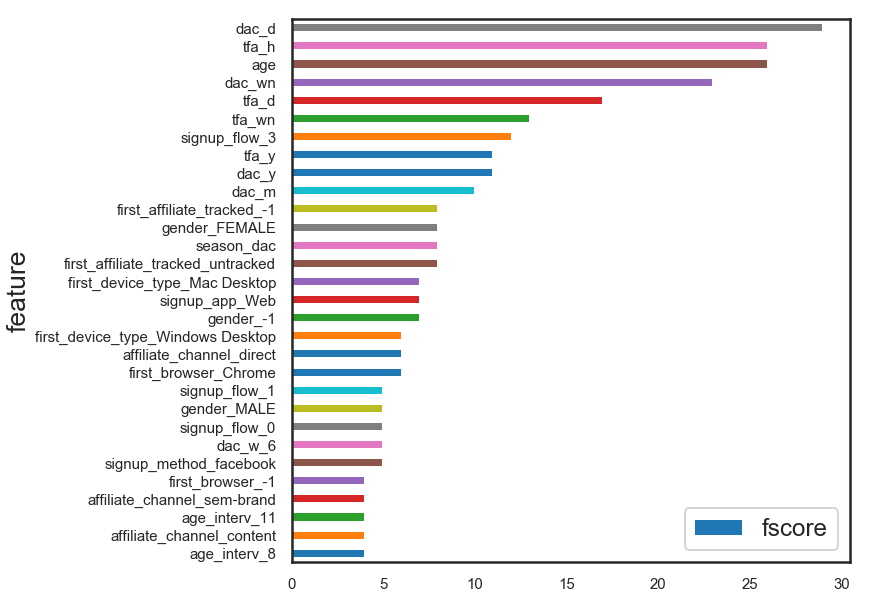

In [171]:
# Plot feature importance of top 30
importance_df.iloc[-30:,:].plot(x='feature',y='fscore',kind='barh',fontsize=15,figsize=(10,10),)

Afterwards, these top 30 features were trained on an XGBoost classifier again over the entire training set with the following parameters:

```
params = {'eta': 0.2,
          'max_depth': 6,
          'subsample': 0.5,
          'colsample_bytree': 0.5,
          'objective': 'multi:softprob',
          'num_class': 12}
          
```

Here, 
- `eta` is the step size shrinkage which is used to prevent overfitting. The default value is 0.3 and we reduced it to make the boosting process more conservative.

- `max_depth` was kept to the default 6. Increasing the max depth was found to increase the training time. The documentation points out that increasing max_depth would increase the complexity and thereby also overfit it.

- `subsample` was set to 0.5 making XGBoost randomly collect half of the data instances to grow trees and this prevents overfitting.

- `colsample_bytree` is the subsample ratio of columns when constructing each tree.

- `objective` was set as `multi:softprob`. I considered `multi:softmax`, `rank:pairwise` as well. Softprob was the most likely candidate from the [documentation](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md#learning-task-parameters). Afterwards, training with `rank:pairwise` improved the result highly.

- `num_class` is the number of classes to predict.

In [172]:
# Now train on X_train, y_train and get NDCG Score
# Only select features w/ a feature score in top 20
# And Retrain model with reduced feature set
users_xg = users[top_features]

vals = users_xg.values
le = LabelEncoder()

X = vals[:piv_train]
y = le.fit_transform(target.values)

X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size = 0.2, random_state = 0)

dtrain = xgb.DMatrix(X_train, y_train)
clf2 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round)

y_pred = clf2.predict(xgb.DMatrix(X_test))

[11:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[11:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[11:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[11:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[11:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[11:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[11:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[11:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[11:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_d

In [173]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from time import time

def train_predict_XG(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    num_boost_round = 1
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    dtrain = xgb.DMatrix(X_train[:sample_size], y_train[:sample_size])
    learner = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round)
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test=learner.predict(xgb.DMatrix(X_test))
    predictions_train=learner.predict(xgb.DMatrix(X_train[:300]))
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    truth = pd.Series(le.inverse_transform(y_train[:300]))
    preds = []
    for i in range(len(predictions_train)):
        preds += [le.inverse_transform(np.argsort(predictions_train[i])[::-1])[:5].tolist()]

    preds = pd.DataFrame(preds)
    results['ncdg_train'] = score_predictions(preds, truth)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    truth = pd.Series(le.inverse_transform(y_test))
    preds = []
    for i in range(len(predictions_test)):
        preds += [le.inverse_transform(np.argsort(predictions_test[i])[::-1])[:5].tolist()]

    preds = pd.DataFrame(preds)
    results['ncdg_test'] = score_predictions(preds, truth)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [174]:
# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
clf2 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round)

samples_100 = len(y_train)
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
clf_name = clf2.__class__.__name__
results[clf_name] = {}
for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict_XG(clf2, samples, X_train, y_train, X_test, y_test)
   

#Run metrics visualization for the three supervised learning models chosen
#vs.evaluate(results, accuracy, fscore)

[11:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[11:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[11:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[11:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[11:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[11:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[11:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[11:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[11:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_d

#### AdaBoost

In [176]:
from time import time

def train_predict_AB(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict_proba(X_test)
    predictions_train = learner.predict_proba(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    truth = pd.Series(le.inverse_transform(y_train[:300]))
    preds = []
    for i in range(len(predictions_train)):
        preds += [le.inverse_transform(np.argsort(predictions_train[i])[::-1])[:5].tolist()]

    preds = pd.DataFrame(preds)
    results['ncdg_train'] = score_predictions(preds, truth)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    truth = pd.Series(le.inverse_transform(y_test))
    preds = []
    for i in range(len(predictions_test)):
        preds += [le.inverse_transform(np.argsort(predictions_test[i])[::-1])[:5].tolist()]

    preds = pd.DataFrame(preds)
    results['ncdg_test'] = score_predictions(preds, truth)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [177]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier
clf_AB = AdaBoostClassifier(random_state = 1)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
clf_name = clf_AB.__class__.__name__
results[clf_name] = {}
for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict_AB(clf_AB, samples, X_train, y_train, X_test, y_test)
   

#Run metrics visualization for the three supervised learning models chosen
#vs.evaluate(results, accuracy, fscore)

AdaBoostClassifier trained on 1707 samples.
AdaBoostClassifier trained on 17076 samples.
AdaBoostClassifier trained on 170760 samples.


In [178]:
results

{'RandomForestClassifier': {0: {'train_time': 0.15073513984680176,
   'pred_time': 0.3396942615509033,
   'ncdg_train': 1.0,
   'ncdg_test': 0.8008288366012501},
  1: {'train_time': 1.2339410781860352,
   'pred_time': 0.4928019046783447,
   'ncdg_train': 0.998769765845238,
   'ncdg_test': 0.8037143976158684},
  2: {'train_time': 30.26617693901062,
   'pred_time': 1.3602261543273926,
   'ncdg_train': 0.9950790633809529,
   'ncdg_test': 0.7977691439128312}},
 'Booster': {0: {'train_time': 0.04216313362121582,
   'pred_time': 0.10486221313476562,
   'ncdg_train': 0.7816682457491332,
   'ncdg_test': 0.7912905568567546},
  1: {'train_time': 0.2519826889038086,
   'pred_time': 0.09398174285888672,
   'ncdg_train': 0.7883743101081088,
   'ncdg_test': 0.8086061780880884},
  2: {'train_time': 3.4656760692596436,
   'pred_time': 0.10257387161254883,
   'ncdg_train': 0.7994541580867885,
   'ncdg_test': 0.8196170491428993}},
 'AdaBoostClassifier': {0: {'train_time': 0.17740702629089355,
   'pred_t

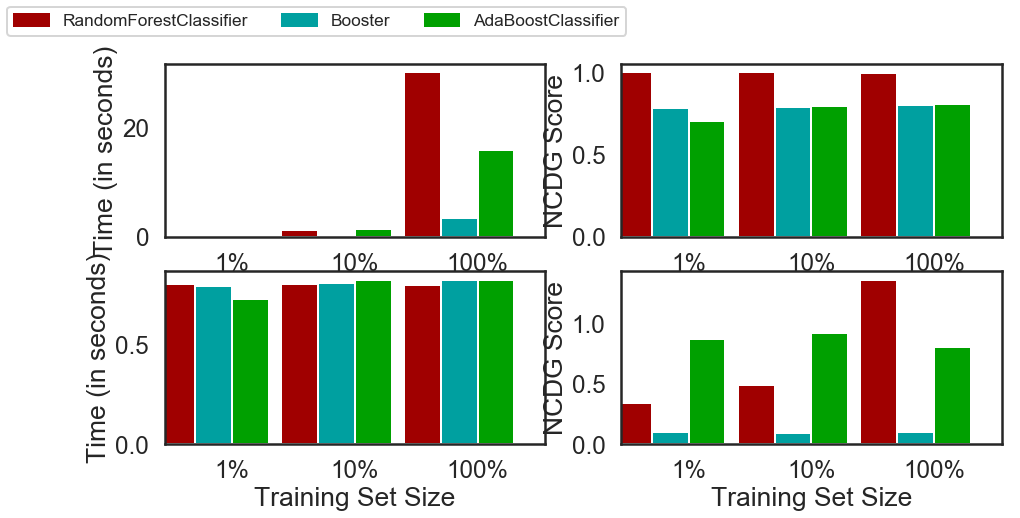

In [181]:
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
fig, ax = pl.subplots(2, 2, figsize = (15,7))

# Constants
bar_width = 0.3
colors = ['#A00000','#00A0A0','#00A000']

for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'ncdg_train', 'ncdg_test', 'pred_time']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//2, j%2].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//2, j%2].set_xticks([0.45, 1.45, 2.45])
                ax[j//2, j%2].set_xticklabels(["1%", "10%", "100%"])
                ax[j//2, j%2].set_xlabel("Training Set Size")
                ax[j//2, j%2].set_xlim((-0.1, 3.0))

# Add unique y-labels
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 1].set_ylabel("NCDG Score")
ax[1, 0].set_ylabel("Time (in seconds)")
ax[1, 1].set_ylabel("NCDG Score")

# Create patches for the legend
patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
            loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    


## IV. Results

Based on the results, since random forest takes the longest time, but when it comes to NCDG score, it gets the best performance. So, I'll choose Random Forest as my final classifier.
Besides, although XG booster gets descent score in the training phase, it gets a very low prediction outcome in testing phase; this indicated phenomena of overfitting. While for adaboost, it performances better than XG boost in both training and testing phases; however, NDGC scores in testing parts are slightly lower than those in training parts.

#### Useing GridSearch for Random Forest

In [182]:
# Uncomment to Load from Checkpoint
users = pd.read_pickle('users_checkpoint1')

#Split data back into train and test sets
vals = users.values
piv_train = len(target)
X = vals[:piv_train]
X_test = vals[piv_train:]

# Create numeric label for each of the 12 target labels
labels = target.values
le = LabelEncoder()
y = le.fit_transform(labels)

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search

clf = RandomForestClassifier(n_estimators=25, random_state=101)
parameters = {'min_samples_split': [2, 20],
              'max_depth': [6, 8]
             }

reg = grid_search.GridSearchCV(clf, parameters, scoring=ndcg_scorer, cv=3)

reg.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 20], 'max_depth': [6, 8]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(ndcg_score, needs_proba=True, k=5), verbose=0)

In [184]:
est = reg.best_estimator_
est

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

In [185]:
y_pred = est.predict_proba(X)

truth = pd.Series(le.inverse_transform(y))
preds = []

for i in range(len(X)):
    preds += [le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()]

preds = pd.DataFrame(preds)
print("Score for Random Forest: " + str(score_predictions(preds, truth)))

Score for Random Forest: 0.8175642777261658


I used sklearns RandomForestClassifier along with Grid Search for cross validation. The parameters used for GridSearch were, `min_samples_split` over `2,20` and `max_depth` over `6,8`. The best estimator over the training dataset was found to be having `min_samples_split = 20` and `max_depth` was found to be `6`. This model was used to predict and got scores: 0.81756

### Justification

One of the important points to discuss about a trained machine learning algorithm is whether it will scale, will it be feasible in the scenario and performance should be consistent with varied data. We can then say whether the model is **robust** or not.
The model, although training with a reduced feature space, gives a better result with the private subset of the training set as can be seen by the results on Kaggle. Also, the training and prediction times were very less due to the feature space reduction step and the NDCG score was also good enough. Depending on the scale of the deployment, the parameters and the number of features can be scaled as well. Hence, the model seems to be robust. Alongside this, the model seems to be trustable and aligns well with our expected solutions outcomes.

## V. Conclusion

### Improvement for NDCG Scoring Function

In [188]:
country_data = 'data/countries.csv'

# Country Data
data_contries = pd.read_csv(country_data)

print('There are {} country data\n'.format(data_contries.shape[0]))
display(data_contries)

print('Maximum value of longitude is {}; while Minimum value is {}\n'.format(max(data_contries['lat_destination']),min(data_contries['lat_destination'])))
print('Maximum value of latitude is {}; while Minimum value is {}'.format(max(data_contries['lng_destination']),min(data_contries['lng_destination'])))

There are 10 country data



,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


Maximum value of longitude is 62.393303; while Minimum value is -26.853388

Maximum value of latitude is 133.27516; while Minimum value is -96.818146


Since Latitude has the range from +90°N to -90°S, 180° totally; while Longitude has the wilder range of -180°W to 180°E, 360° totally. Here I re-define Longitude to be the value within 0° to 180° (Since -180° locates at the same point with 180°), so I replace negative value of longitude, x, to be (180+x).

In [189]:
for idx in range(data_contries.shape[0]):
    if data_contries['lng_destination'][idx] < 0:
        data_contries['lng_destination'][idx] = 360+data_contries['lng_destination'][idx]

display(data_contries)
print('Maximum value of latitude is {}; while Minimum value is {}\n'.format(max(data_contries['lat_destination']),min(data_contries['lat_destination'])))
print('Maximum value of longitude is {}; while Minimum value is {}'.format(max(data_contries['lng_destination']),min(data_contries['lng_destination'])))

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,263.181854,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,357.512306,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,356.567723,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,352.160681,7355.2534,92090.0,por,95.45
9,US,36.966427,264.155970,0.0000,9826675.0,eng,0.00


Maximum value of latitude is 62.393303; while Minimum value is -26.853388

Maximum value of longitude is 357.5123055; while Minimum value is 2.2096669999999996


In [190]:
dictLat={};
dictLng={};
for idx in range(data_contries.shape[0]):
    dictLat[data_contries['country_destination'][idx]] = data_contries['lat_destination'][idx]
    dictLng[data_contries['country_destination'][idx]] = data_contries['lng_destination'][idx]

print(dictLat['FR'])
print(dictLng)

46.232193
{'AU': 133.27516, 'CA': 263.181854, 'DE': 10.452764, 'ES': 357.5123055, 'FR': 2.2096669999999996, 'GB': 356.5677226, 'IT': 12.564167, 'NL': 5.29525, 'PT': 352.160681, 'US': 264.15597}


Actual and Predict destination has Range for longitude between [0, 89.246691]
                                                                latitude   between [0, 175.3026385]
1. A perfect answer (gain = 3)
difference in longitude < 20 and
difference in latitude < 40 and

2. A good answer (gain = 2)
difference in longitude < 40 and
difference in latitude < 80 and

3. A relevant answer (gain = 1)
difference in longitude < 60 and
difference in latitude < 120 and

4. An incorrect answer (gain = 0)
Others

In [191]:
def getGain(target, pred):
    if target in dictLat:
        tar_lat = dictLat[target]
        tar_lng = dictLng[target]
    else:
        return 0
    
    if pred in dictLat:
        pred_lat = dictLat[pred]
        pred_lng = dictLng[pred]
    else:
        return 0
    
    if abs(tar_lng-pred_lng) <= 20.0 and abs(tar_lat-pred_lat) <= 40.0:
        return 3
    elif abs(tar_lng-pred_lng) <= 40.0 and abs(tar_lat-pred_lat) <= 80.0:
        return 2
    elif abs(tar_lng-pred_lng) <= 60.0 and abs(tar_lat-pred_lat) <= 120.0:
        return 1
    else:
        return 0
    
def dcg_at_k(r, k, method=1):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k=5, method=1):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def score_predictions(preds, truth, n_modes=5):
    """
    preds: pd.DataFrame
      one row for each observation, one column for each prediction.
      Columns are sorted from left to right descending in order of likelihood.
    truth: pd.Series
      one row for each obeservation.
    """
    assert(len(preds)==len(truth))
    r = pd.DataFrame(0, index=preds.index, columns=preds.columns, dtype=np.float64)
    for row in np.arange(preds.shape[0]):
        target=truth[row]
        for col in preds.columns:
            r[col][row] = getGain(target,preds[col][row])
    
    score = pd.Series(r.apply(ndcg_at_k, axis=1, reduce=True), name='score')
    return score.mean()

In [192]:
"""Metrics to compute the model performance."""
# ref: https://www.kaggle.com/davidgasquez/airbnb-recruiting-new-user-bookings/ndcg-scorer
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.
        
    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    #lb.fit(range(len(predictions) + 1))  ## original
    #lb.fit(range(predictions.shape[1] + 1))
    #T = lb.transform(ground_truth)
    
    T = lb.fit_transform(ground_truth) 

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [193]:
preds = pd.DataFrame([['US','FR']])
truth = pd.Series(['FR'])

print(score_predictions(preds, truth))

0.6309297535714574


#### Random Forest

In [194]:
# Uncomment to Load from Checkpoint
users = pd.read_pickle('users_checkpoint1')

In [195]:
# Create numeric label for each of the 12 target labels
labels = target.values
le = LabelEncoder()
y = le.fit_transform(labels)
print(y)

[ 7  7 10 ...  7  7  7]


In [196]:
#Split data back into train and test sets
vals = users.values
piv_train = len(target)
X = vals[:piv_train]
X_test = vals[piv_train:]

# Create numeric label for each of the 12 target labels
labels = target.values
le = LabelEncoder()
y = le.fit_transform(labels)

In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search

clf = RandomForestClassifier(n_estimators=25, random_state=101)
parameters = {'min_samples_split': [2, 20],
              'max_depth': [6, 8]
             }

reg = grid_search.GridSearchCV(clf, parameters, scoring=ndcg_scorer, cv=3)

reg.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 20], 'max_depth': [6, 8]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(ndcg_score, needs_proba=True, k=5), verbose=0)

In [198]:
est = reg.best_estimator_
est

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

In [199]:
y_pred = est.predict_proba(X)

truth = pd.Series(le.inverse_transform(y))
preds = []

for i in range(len(X)):
    preds += [le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()]

preds = pd.DataFrame(preds)
print("Score for Random Forest with modified NDCG: " + str(score_predictions(preds, truth)))

Score for Random Forest with modified NDCG: 0.23344088787190673


As I showed above, after put distance information into NDCG evaluation model, the final scores dramatically dropping down, from 0.8 to 0.2. Because we evaluate 5 possible destinations and 5 of them will get their gains based on the different between Latitude and Longitude. The reason why this evaluation model is not useful here is that in this case, we only put 10 target counties as our prediction results. Some countries locate very far away from others, so when predicting, the other possible candidates will force the final score to be lowered since no matter what they predict, the predictions are very far from the target.

If we can access the dataset with much more destination counties to handle, at the same time, if I have GPU environment to process, then I believe this modified NDCG with our classifiers will have a better results.